# Leveraging Big Multitemporal Multisource Satellite Data and Artificial Intelligence for the Detection of Complex and Invisible Features - the Case of Extensive Irrigation Mapping


Nazarij Buławka 1*, Hector A. Orengo 2, 3, Felipe Lumbreras Ruiz 4 , Iban Berganzo-Besga 3 and Ekta Gupta 5

1.	Non-Invasive and Digital Archeology Laboratory (PANiC), Faculty of Archaeology, University of Warsaw
2.	Catalan Institution for Research and Advanced Studies (ICREA)
3.	Computational Social Sciences and Humanities Department, Barcelona Supercomputing Center
4.	Department of Computer Science, Universidad Autónoma de Barcelona,
5.	Landscape Archaeology Research Group (GIAP), Catalan Institute of Classical Archaeology


 ## Levee detection demo

The file contains the demonstration of the Swin UNETR model for the detection of the levees. The original model is run in the Docker environment, which is published in the GitHub repository.


The demo consist of six steps

1. Setup
2. Download the data and the model
3. Predict the levees
4. Apply post-processing
5. Evaluate the results
6. Visualise the results


# Citation

Buławka, Nazarij, Hector A. Orengo, Felipe Lumbreras Ruiz, Iban Berganzo-Besga and Ekta Gupta. n.d. ‘Leveraging Big Multitemporal Multisource Satellite Data and Artificial Intelligence for the Detection of Complex and Invisible Features - the Case of Extensive Irrigation Mapping’.


## 1. Setup

### Clone the repository

In [ ]:
!git clone https://github.com/nazarb/Levees_DL.git

Cloning into 'Levees_DL'...
remote: Enumerating objects: 998, done.
remote: Counting objects: 100% (411/411), done.
remote: Compressing objects: 100% (269/269), done.
remote: Total 998 (delta 308), reused 142 (delta 142), pack-reused 587 (from 2)
Receiving objects: 100% (998/998), 3.01 MiB | 19.50 MiB/s, done.
Resolving deltas: 100% (482/482), done.


### Set up path for further processing

In [ ]:
import os
basepath = os.getcwd()
print(basepath)
# set other paths for quick navigation
git_path = os.path.join(basepath, "Levees_DL")
print(git_path)
Swin_UNETR_path = os.path.join(git_path, "Swin_UNETR")
print(Swin_UNETR_path)
model_path = os.path.join(Swin_UNETR_path, "model/Swin_UNETR/Aug")
results_path = os.path.join(Swin_UNETR_path, "results/Swin_UNETR/Aug")
rasters_path = os.path.join(git_path, "Rasters")
os.makedirs(results_path, exist_ok=True)
os.makedirs(rasters_path, exist_ok=True)

print(results_path)


/content
/content/Levees_DL
/content/Levees_DL/Swin_UNETR
/content/Levees_DL/Swin_UNETR/results/Swin_UNETR/Aug


### Install libraries

In [ ]:
!pip install --no-cache-dir monai==1.3.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.9 MB/s eta 0:00:00


In [ ]:
!sudo apt install megatools
!pip install rasterio


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  megatools
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 207 kB of archives.
After this operation, 898 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 megatools amd64 1.10.3-1build1 [207 kB]
Fetched 207 kB in 1s (145 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package megatools.
(Reading database ... 121689 files and directorie

In [ ]:

import warnings
warnings.filterwarnings("ignore")
import torch
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'Tesla T4'

## 2. Download the data and the model

The raster data used in this study is calculated with the provided Google Earth Engine code. The model is published in the Dane Badawcze UW repository (Published version: 2025-09-24):

```
Buławka, Nazarij; Orengo, Hector A.; Lumbreras Ruiz, Felipe; Berganzo-Besga, Iban; Gupta, Ekta, 2025, "Traces of ancient irrigation in central Iraq detected using deep learning model", https://doi.org/10.58132/MY8CCL, Dane Badawcze UW, V1
```


In [ ]:
import os
import shutil
import requests
import os
import shutil

# Download data the raster calculated with provided Google Earth Engine code
# MEGA file URL
mega_url = "https://mega.nz/file/E9gBCCjR#UCDklOgOVOwQ0hRAIy5pvAdX9Y-VLBQktDlsrj4R1Ms"
sector = "CFE_a"
file_to_detect = "CFE_a_selected_L5_S2_S1_MSRM_PCA_GLO_N48.tif"
downloaded_file = os.path.join(rasters_path, file_to_detect)

# Download file using megadl
!megadl "{mega_url}" --path "{rasters_path}"




Downloaded CFE_a_selected_L5_S2_S1_MSRM_PCA_GLO_N48.tif


In [ ]:
# Download the model from the Dane Badawcze UW repository (Published version: 2025-09-24):
## Buławka, Nazarij; Orengo, Hector A.; Lumbreras Ruiz, Felipe; Berganzo-Besga, Iban; Gupta, Ekta, 2025, "Traces of ancient irrigation in central Iraq detected using deep learning model", https://doi.org/10.58132/MY8CCL, Dane Badawcze UW, V1

## URL of the file
url = "https://danebadawcze.uw.edu.pl/api/access/datafile/17759"

## Download location
download_path = "/content/Levees_SWINUNETR_48_best_dataset_F.pth"

## Target directory
target_dir2 = model_path

os.makedirs(target_dir2, exist_ok=True)  # create dir if it doesn't exist

## Download the file
print("Downloading...")
response = requests.get(url, stream=True)
with open(download_path, "wb") as f:
    shutil.copyfileobj(response.raw, f)
print("Download complete.")

3# Move to target directory
final_path = os.path.join(target_dir2, "Levees_SWINUNETR_48_best_dataset_F.pth")
shutil.move(download_path, final_path)
print(f"File moved to: {final_path}")



Downloading...
Download complete.
File moved to: /content/Levees_DL/Swin_UNETR/model/Swin_UNETR/Aug/Levees_SWINUNETR_48_best_dataset_F.pth


## 3. Predict the levees
Area: southeast of Babylon


In [ ]:
# Check the paths for further processing

model_path
# Swin_UNETR_pth = os.path.join(target_dir2, "Levees_SWINUNETR_48_best.pth")
Swin_UNETR_pth = os.path.join(model_path, "Levees_SWINUNETR_48_best_dataset_F.pth")

print({Swin_UNETR_pth})
#data_path =  os.path.join(target_dir1, "CFE_a_selected_L5_S2_S1_MSRM_PCA_GLO_N48.tif")
data_path =  os.path.join(rasters_path, file_to_detect)
print(data_path)


{'/content/Levees_DL/Swin_UNETR/model/Swin_UNETR/Aug/Levees_SWINUNETR_48_best_dataset_F.pth'}
/content/Levees_DL/Rasters/CFE_a_selected_L5_S2_S1_MSRM_PCA_GLO_N48.tif


In [ ]:
#import monai
#from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
#import einops
#import warnings
#import json
#import numpy as np
import torch
#from torch.utils.data import Dataset, DataLoader
import os
#
#from rasterio.windows import Window
#import tifffile as tiff
from Levees_DL.utils import get_filename_without_extension
from Levees_DL.utils import predict_and_save
from Levees_DL.utils import convert_tiles_to_npy
from Levees_DL.utils import save_full_raster
from Levees_DL.utils.datasets import NumpyDataset
from Levees_DL.utils import load_large_image
from Levees_DL.utils import prepare_test_loader, split_to_tiles, create_tfw_file


filename_to_detect = get_filename_without_extension(data_path)


def initialize_model():
    """Initialize the SwinUNETR model."""
    model = SwinUNETR(
        img_size=(96, 96),
        in_channels=48,
        out_channels=1,  # Use the passed `num_classes`
        use_checkpoint=True,
        feature_size=48,
        depths=(3, 9, 18, 3),
        num_heads=(4, 8, 16, 32),
        drop_rate=0.1,  # Added dropout
        attn_drop_rate=0.1,
        dropout_path_rate=0.2,
        spatial_dims=2
    )
    return model


def load_adapted_model(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint, strict=False)
    return model




if __name__ == "__main__":
    image_path = data_path

    tile_size = 96
    batch_size = 12
    model = initialize_model()

    print("Loading and preprocessing the large image")
    large_image, transform = load_large_image(image_path)
    large_image = NumpyDataset.replace_nans_in_array(large_image)
    image_shape = large_image.shape
    print(f"Large image shape: {image_shape}")

    temp_dir = f'{Swin_UNETR_path}/results/temp/'
    npy_dir = f'{Swin_UNETR_path}/results/temp_npy/'
    pred_dir = f'{Swin_UNETR_path}/results/temp_pred/'
    result_path = f'{Swin_UNETR_path}/results/Swin_UNETR/Aug/{filename_to_detect}_swinunetr.tif'
    tfw_path = f'{Swin_UNETR_path}/results/Swin_UNETR/Aug/{filename_to_detect}_swinunetr.tfw'

    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

    tile_paths = split_to_tiles(large_image, tile_size, temp_dir)
    npy_paths = convert_tiles_to_npy(tile_paths, npy_dir)
    test_loader = prepare_test_loader(npy_paths, batch_size)

    adapted_model_path = Swin_UNETR_pth
    model = load_adapted_model(model, adapted_model_path)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    predictions = predict_and_save(model, test_loader, device, tile_paths, save_dir=pred_dir)

    # Adjust the image_shape to reflect the single-channel output
    single_channel_image_shape = (1, image_shape[1], image_shape[2])
    save_full_raster(predictions, single_channel_image_shape, tile_size, result_path)

    # Create the .tfw file using the transform from the original large image
    create_tfw_file(transform, tfw_path)

    print("Prediction, saving, and .tfw file creation complete")



Loading and preprocessing the large image
Loading large image from /content/Levees_DL/Rasters/CFE_a_selected_L5_S2_S1_MSRM_PCA_GLO_N48.tif
Large image shape: (48, 2994, 1746)
Splitting image into tiles of size 96x96
Saving tile to /content/Levees_DL/Swin_UNETR/results/temp/tile_0_0.tif
Saving tile to /content/Levees_DL/Swin_UNETR/results/temp/tile_0_96.tif
Saving tile to /content/Levees_DL/Swin_UNETR/results/temp/tile_0_192.tif
Saving tile to /content/Levees_DL/Swin_UNETR/results/temp/tile_0_288.tif
Saving tile to /content/Levees_DL/Swin_UNETR/results/temp/tile_0_384.tif
Saving tile to /content/Levees_DL/Swin_UNETR/results/temp/tile_0_480.tif
Saving tile to /content/Levees_DL/Swin_UNETR/results/temp/tile_0_576.tif
Saving tile to /content/Levees_DL/Swin_UNETR/results/temp/tile_0_672.tif
Saving tile to /content/Levees_DL/Swin_UNETR/results/temp/tile_0_768.tif
Saving tile to /content/Levees_DL/Swin_UNETR/results/temp/tile_0_864.tif
Saving tile to /content/Levees_DL/Swin_UNETR/results/temp

## 4. Apply post-processing

In [ ]:
import numpy as np
import cv2
import os
from skimage import io
from Levees_DL.utils import create_tfw_file
from Levees_DL.utils import load_large_binary_image

## Load image for post-processing. You can use result_path from the previous step or use input
# # raster_r = input("Enter path to raster data: ").strip('"') # input

raster_r = result_path # the result_path from the previous step
filename_to_detect = get_filename_without_extension(raster_r) # get the thename for further processing
binary_raster, transform = load_large_binary_image(raster_r) # load image for prediction
binary_raster = (binary_raster > 0).astype(np.uint8)  # Ensure binary

# REMOVE SMALL OBJECTS
min_area = 350
#num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_raster, connectivity=8)
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_raster, connectivity=8)

# Keep only features above the selected min_area parameter
filtered_raster = np.zeros_like(binary_raster, dtype=np.uint8)
for i in range(1, num_labels):  # skip background
    if stats[i, cv2.CC_STAT_AREA] >= min_area:
        filtered_raster[labels == i] = 1


# Output
output_dir = results_path
os.makedirs(output_dir, exist_ok=True)
filtered_dir = os.path.join(output_dir, "Filtered")
os.makedirs(filtered_dir, exist_ok=True)

# Save
filtered_tif_path = os.path.join(filtered_dir, f'{filename_to_detect}_filtered.tif')
io.imsave(filtered_tif_path, (filtered_raster * 1).astype(np.uint8))
create_tfw_file(transform, os.path.splitext(filtered_tif_path)[0] + '.tfw')

print("Filtering complete. Small features removed and .tfw file saved.")

# CLOSING
kernel = np.ones((7,7),np.uint8)
closing_raster = cv2.morphologyEx(filtered_raster, cv2.MORPH_CLOSE, kernel)

# SAVE CLOSING results
closing_tif_path = os.path.join(filtered_dir, f'{filename_to_detect}_closing.tif')
cv2.imwrite(closing_tif_path, (closing_raster * 1).astype(np.uint8))
create_tfw_file(transform, os.path.splitext(closing_tif_path)[0] + '.tfw')



Loading large image from /content/Levees_DL/Swin_UNETR/results/Swin_UNETR/Aug/CFE_a_selected_L5_S2_S1_MSRM_PCA_GLO_N48_swinunetr.tif
Creating .tfw file at /content/Levees_DL/Swin_UNETR/results/Swin_UNETR/Aug/Filtered/CFE_a_selected_L5_S2_S1_MSRM_PCA_GLO_N48_swinunetr_filtered.tfw
Filtering complete. Small features removed and .tfw file saved.
Creating .tfw file at /content/Levees_DL/Swin_UNETR/results/Swin_UNETR/Aug/Filtered/CFE_a_selected_L5_S2_S1_MSRM_PCA_GLO_N48_swinunetr_closing.tfw


## 5. Evaluate the results


### Download the reference data


In [ ]:
# Download the reference data



# MEGA file URL
mega_url2 = "https://mega.nz/file/5txRRQiZ#dDRqdI4F695r7yG465W5KIISVdQ1Iw2O8EWK2BIdoFs"

# Temporary download path (megadl saves the file with original name by default)
reference_path = f'{git_path}/Reference'
os.makedirs(reference_path, exist_ok=True)
downloaded_file = os.path.join(reference_path, "CFE_a_levee_reference.tif")


# Download file using megadl
!megadl "{mega_url2}" --path "{reference_path}"



Reference_data_path = os.path.join(reference_path, "CFE_a_levee_reference.tif")


Downloaded CFE_a_levee_reference.tif


### Compare the predicted levees and the reference data - raster version

In [ ]:
import os
from Levees_DL.utils import read_tfw_coordinates
from Levees_DL.utils import align_reference_with_crs
from rasterio.crs import CRS
from Levees_DL.utils import compare_rasters
from rasterio.crs import CRS


reference_tif = Reference_data_path

#reference_tif = input("Enter path to reference data: ").strip('"') # If manual selection is needed
predicted_tif = closing_tif_path
#predicted_tif = input("Enter path to predicted data: ").strip('"') # If manual selection is needed


# Step 1: Read transform from TFW file
predicted_transform = read_tfw_coordinates(predicted_tif)

# Step 1b: Define CRS manually (replace EPSG code as needed!)
dst_crs = CRS.from_epsg(4326)   #

# Step 2: Align reference raster
aligned_ref_path = os.path.splitext(predicted_tif)[0] + "_ref_aligned.tif"
aligned_ref = align_reference_with_crs(reference_tif, predicted_tif, predicted_transform, dst_crs, aligned_ref_path)


metrics = compare_rasters(
    reference_tif=aligned_ref,
    predicted_tif=predicted_tif,
    IoU_buf=4,
    output_path="custom_comparison.tif"
)

print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")
print(f"IoU: {metrics['iou']:.4f}")



[TFW] Affine transform read from file:



--- Evaluation Metrics ---
Precision:  0.6160
Recall:     0.5504
F1 Score:   0.5813
IoU:        0.4098
Comparison raster saved to:
custom_comparison.tif
Precision: 0.6160
Recall: 0.5504
F1 Score: 0.5813
IoU: 0.4098


The evaluation of the last version of the model after post-processing (min_area=350) using Copernicus DEM GLO 30

| Dataset* | Model      | Test area | Prediction         | Precision | Recall | F1 Score | IoU    |
|----------|------------|-----------|--------------------|-----------|--------|----------|--------|
| F        | Swin UNETR | 1a        | Filtered + Closing | 0.4661    | 0.6142 | 0.5300   | 0.3605 |
| F        | Swin UNETR | 1b        | Filtered + Closing | 0.4675    | 0.6329 | 0.5377   | 0.3678 |
| F        | Swin UNETR | 1c        | Filtered + Closing | 0.4735    | 0.6265 | 0.5393   | 0.3692 |
| F        | Swin UNETR | 1d        | Filtered + Closing | 0.4389    | 0.6590 | 0.5269   | 0.3577 |
| F        | Swin UNETR | 1e        | Filtered + Closing | 0.3938    | 0.5753 | 0.4676   | 0.3051 |
| F        | Swin UNETR | 1f        | Filtered + Closing | 0.4231    | 0.6062 |  0.4984  | 0.3319 |
| Average  | Swin UNETR |           | Filtered + Closing | 0.4438    | 0.6190 | 0.5167   | 0.3487 |


### Reproject the results


In [ ]:
from Levees_DL.utils import reproject_raster

reprojected_ouput_file = f'{filtered_dir}/{filename_to_detect}_swinunetr_closing_3857.tfw'

# Using TFW file for transform information
output = reproject_raster(
    closing_tif_path,
    reprojected_ouput_file,
    src_crs="EPSG:4326",
    dst_crs="EPSG:3857",
    use_tfw=True
)


[TFW] Affine transform read from file:
Reprojected raster saved to: /content/Levees_DL/Swin_UNETR/results/Swin_UNETR/Aug/Filtered/CFE_a_selected_L5_S2_S1_MSRM_PCA_GLO_N48_swinunetr_swinunetr_closing_3857.tfw


#### Skeletonise

In [ ]:
# # Code created by Orengo, Hector A. (2026) 2026. Horengo/RasterToNetwork. Jupyter Notebook. January 21, released January 24. https://github.com/horengo/RasterToNetwork.

from Levees_DL.utils import skeletonize_raster

in_raster = reprojected_ouput_file
out_raster = os.path.join(filtered_dir, f'{filename_to_detect}_skeleton.tif')
skeldir = out_raster

binarize = lambda arr: (arr > 0)

out_raster = skeletonize_raster(
    in_raster=in_raster,
    out_raster=out_raster,
    binarize=binarize  # Optional: defaults to lambda arr: (arr > 0)
)

print(f"Done. Wrote skeleton raster: {out_raster}")

Done. Wrote skeleton raster: /content/Levees_DL/Swin_UNETR/results/Swin_UNETR/Aug/Filtered/CFE_a_selected_L5_S2_S1_MSRM_PCA_GLO_N48_swinunetr_skeleton.tif


### Remove short lines

In [ ]:
# # Code created by Orengo, Hector A. (2026) 2026. Horengo/RasterToNetwork. Jupyter Notebook. January 21, released January 24. https://github.com/horengo/RasterToNetwork.

# Connected-pixel filtering of a binary channel raster (remove small components)
# - Reads a binary raster (0/1 or 0/255 etc.)
# - Labels connected components
# - Removes components with fewer than `min_pixels` pixels
# - Writes a filtered binary raster with the same georeferencing

from Levees_DL.utils import filter_connected_components

in_raster = skeldir
min_pixels = 50          # remove components smaller than this (in pixels)
connectivity = 8         # 4 or 8 (8 is usually better for channel networks)
out_raster = os.path.join(filtered_dir, f'{filename_to_detect}_skeleton_{min_pixels}_{connectivity}.tif')
skeldir_sm = out_raster

# If your raster is not strictly 0/1, define how to binarize it:
# e.g., channels are values > 0
binarize = lambda arr: (arr > 0)

# ---------------------

# Use utils function to filter connected components
out_raster = filter_connected_components(
    in_raster=in_raster,
    out_raster=out_raster,
    min_pixels=min_pixels,
    connectivity=connectivity,
    binarize=binarize  # Optional: defaults to lambda arr: (arr > 0)
)

print(f"Done. Wrote: {out_raster}")
print(f"Removed components with < {min_pixels} pixels (connectivity={connectivity}).")

Done. Wrote: /content/Levees_DL/Swin_UNETR/results/Swin_UNETR/Aug/Filtered/CFE_a_selected_L5_S2_S1_MSRM_PCA_GLO_N48_swinunetr_skeleton_50_8.tif
Removed components with < 50 pixels (connectivity=8).


In [ ]:
!pip install sknw
!pip install geopandas shapely

### Convert to vector

In [ ]:
# # Code created by Orengo, Hector A. (2026) 2026. Horengo/RasterToNetwork. Jupyter Notebook. January 21, released January 24. https://github.com/horengo/RasterToNetwork.

# Cell: Transform a filtered skeleton raster (0/1) into a network with:
#  - endpoint↔endpoint gap bridging (angle + distance)
#  - endpoint→vertex snapping (attach dangling endpoints to nearby line vertices)
#  - degree-2 contraction (analysis network)
#  - optional parallel/near-parallel connector creation (with proper node insertion)
#  - optional directionality from a slope-direction/aspect raster
# 1. Install dependencies (if not already done)
# !pip install sknw geopandas shapely  # Already done

# 2. Reload the module
import importlib
import sys

# Clear the cached module
if 'Levees_DL.utils.raster_to_network' in sys.modules:
    del sys.modules['Levees_DL.utils.raster_to_network']

# Re-import
from Levees_DL.utils.raster_to_network import raster_to_network as build_network

# 3. Verify sknw is available
import sknw
print("✓ sknw is available")

# ---- USER PARAMS ------------------------------------------------------------
in_skeleton = skeldir_sm
out_gpkg = os.path.join(filtered_dir, f'{filename_to_detect}_skeleton_{min_pixels}_{connectivity}_network.gpkg')
net_dir = out_gpkg

# Geometry clean-up (map units)
simplify_tol = None          # if None, auto ~ 0.5 pixel
smooth_iters = 2             # 0 disables smoothing; 1-3 typical
smooth_then_simplify = True  # re-simplify after smoothing

# ---- Gap filling: endpoint -> endpoint (done post-contraction) ----
bridge_endpoints = True
max_gap_dist = 900.0
max_angle_deg = 65.0
direction_step = 3
max_bridges_per_endpoint = 1
max_bridge_rounds = 2

# ---- Gap filling: endpoint -> vertex snapping ----
bridge_to_vertices = True
max_snap_dist = 600.0
max_snap_angle_deg = 45.0
max_target_angle_deg = 90.0
max_vertex_snaps_per_endpoint = 1
vertex_candidate_stride = 1

# ---- Optional directionality from a slope/aspect/flow-direction raster ----
slope_dir_raster = None
slope_dir_convention = "cw_from_north"
slope_dir_is_downhill = True

# ---- Optional costs per edge from a cost raster ----
cost_raster = None
cost_nodata_to_nan = True
cost_sampling_step = None
cost_unique_cells = True

# ---- Join closely running (parallel / near-parallel) lines ----
join_parallel_lines = False
parallel_max_dist = 40.0
parallel_max_angle_deg = 15.0
parallel_min_length = 50.0
max_parallel_connectors = 200
# ----------------------------------------------------------------------------

# Run the complete pipeline
result = build_network(
    in_skeleton=in_skeleton,
    out_gpkg=out_gpkg,
    simplify_tol=simplify_tol,
    smooth_iters=smooth_iters,
    smooth_then_simplify=smooth_then_simplify,
    bridge_endpoints=bridge_endpoints,
    max_gap_dist=max_gap_dist,
    max_angle_deg=max_angle_deg,
    direction_step=direction_step,
    max_bridges_per_endpoint=max_bridges_per_endpoint,
    max_bridge_rounds=max_bridge_rounds,
    bridge_to_vertices=bridge_to_vertices,
    max_snap_dist=max_snap_dist,
    max_snap_angle_deg=max_snap_angle_deg,
    max_target_angle_deg=max_target_angle_deg,
    max_vertex_snaps_per_endpoint=max_vertex_snaps_per_endpoint,
    vertex_candidate_stride=vertex_candidate_stride,
    slope_dir_raster=slope_dir_raster,
    slope_dir_convention=slope_dir_convention,
    slope_dir_is_downhill=slope_dir_is_downhill,
    cost_raster=cost_raster,
    cost_nodata_to_nan=cost_nodata_to_nan,
    cost_sampling_step=cost_sampling_step,
    cost_unique_cells=cost_unique_cells,
    join_parallel_lines=join_parallel_lines,
    parallel_max_dist=parallel_max_dist,
    parallel_max_angle_deg=parallel_max_angle_deg,
    parallel_min_length=parallel_min_length,
    max_parallel_connectors=max_parallel_connectors,
)

# Access results if needed
nodes_gdf = result['nodes_gdf']
edges_gdf = result['edges_gdf']
stats = result['stats']

✓ sknw is available
Wrote network to: /content/Levees_DL/Swin_UNETR/results/Swin_UNETR/Aug/Filtered/CFE_a_selected_L5_S2_S1_MSRM_PCA_GLO_N48_swinunetr_skeleton_50_8_network.gpkg (layers: nodes, edges)
Original sknw export: nodes=2032 edges=1921
Contracted:          nodes=1997 edges=1886
Final:              nodes=2096 edges=2220
simplify_tol=11.4 smooth_iters=2


In [ ]:
# # Code created by Orengo, Hector A. (2026) 2026. Horengo/RasterToNetwork. Jupyter Notebook. January 21, released January 24. https://github.com/horengo/RasterToNetwork.

# Add connectivity metrics directly into the existing nodes/edges tables:
#  1) Read nodes+edges from an existing GPKG
#  2) Compute metrics with NetworkX
#  3) Write new GeoPackage file with metrics

from Levees_DL.utils.network_metrics import compute_network_metrics as cnm


# ---- USER PARAMS ----
gpkg_in = net_dir
gpkg_out = os.path.join(filtered_dir, f'{filename_to_detect}_skeleton_{min_pixels}_{connectivity}_network_metrics.gpkg')
metrics_dir = gpkg_out

# Graph options
directed = False
use_weights = True
length_col = "length"

# Extra/slow metrics
compute_current_flow = False
compute_local_edge_connectivity = False
overwrite_in_place = False

# ---------------------

# Run the metrics computation
result = cnm(
    gpkg_in=gpkg_in,
    gpkg_out=gpkg_out,
    nodes_lyr="nodes",
    edges_lyr="edges",
    overwrite_in_place=overwrite_in_place,
    directed=directed,
    use_weights=use_weights,
    length_col=length_col,
    compute_current_flow=compute_current_flow,
    compute_local_edge_connectivity=compute_local_edge_connectivity,
)

# Access results if needed
nodes_gdf = result['nodes_gdf']
edges_gdf = result['edges_gdf']
stats = result['stats']

print(f"Computed metrics for {stats['num_nodes']} nodes and {stats['num_edges']} edges")

Writing with engine: pyogrio
Written: /content/Levees_DL/Swin_UNETR/results/Swin_UNETR/Aug/Filtered/CFE_a_selected_L5_S2_S1_MSRM_PCA_GLO_N48_swinunetr_skeleton_50_8_network_metrics.gpkg
Layers overwritten in output: nodes, edges
Computed metrics for 2096 nodes and 2220 edges


### Calculate metrics for predicted levee data


#### Download the reference data

In [ ]:
!git clone https://github.com/nazarb/Radogost_FileList.git

Cloning into 'Radogost_FileList'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 63 (delta 28), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 53.04 KiB | 6.63 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [ ]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from Radogost_FileList.utils.dataset_downloader_with_doi import DatasetDownloader

reference_data_path = os.path.join(basepath, "Reference")

In [ ]:
#Create downloader instance
downloader = DatasetDownloader(verbose=True)

# Download FileList from URL
downloader.download_filelist(
    "https://doi.org/10.58132/MGOHM8",
    output_path=f"{reference_data_path}/FileList.json"
)

# Download all files
downloader.download_dataset(
    target_dir=f"{reference_data_path}/data",
    skip_existing=True,
    delay=0.5,
    create_structure=True
)

# Check statistics
print(f"Downloaded {downloader.stats['files_downloaded']} files")
print(f"Total size: {downloader._format_size(downloader.stats['bytes_downloaded'])}")

Detected DOI URL, resolving...
Resolving DOI URL: https://doi.org/10.58132/MGOHM8
DOI resolved to: https://danebadawcze.uw.edu.pl/dataset.xhtml?persistentId=doi:10.58132/MGOHM8
FileList link not found in HTML, trying common patterns...
Dataset DOI ID: 10.58132/MGOHM8
Found 12 file references
Testing: https://danebadawcze.uw.edu.pl/api/access/datafile/18890
✓ Found FileList.json: https://danebadawcze.uw.edu.pl/api/access/datafile/18890
✓ Saved FileList.json to: /content/Reference/FileList.json
✓ FileList.json loaded successfully

Skip existing files: True
Create folder structure: True

Total files to process: 11

[1/11] ↓ Downloading readme.txt...
✓            ✓ 10.6 KB
[2/11] ↓ Downloading style-levee-extended.qml...
✓            ✓ 36.4 KB
[3/11] ↓ Downloading style-river.qml...
✓            ✓ 39.5 KB
[4/11] ↓ Downloading style.qml...
✓            ✓ 38.2 KB
[5/11] ↓ Downloading UnderTheSands_Iraq_CFE_Network_of_levees_and_palaeo_channels.cpg...
✓            ✓ 5.0 B
[6/11] ↓ Downloading

#### Visualise the entire Reference dataset


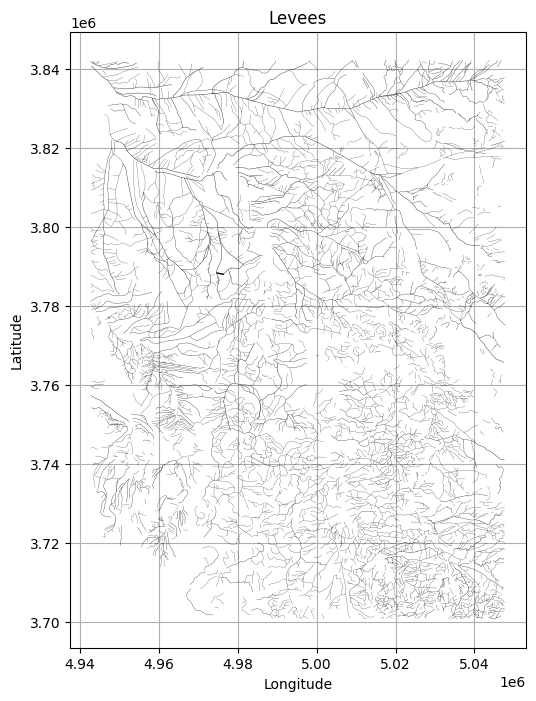

In [ ]:


# === Path to your shapefile ===
shp_path = f"{reference_data_path}/data/vector/UnderTheSands_Iraq_CFE_Network_of_levees_and_palaeo_channels.shp"

# === Load shapefile ===
gdf = gpd.read_file(shp_path)

# === Filter by Type == 2 ===
gdf = gdf[gdf["Type"] == 2]

if gdf.empty:
    raise ValueError("No features found with Type == 2.")

# === Define mapping from Size to linewidth ===
# You can adjust these if you want different visual scaling
size_to_width = {
    0.25: 0.15,
    0.5: 0.2,
    0.75: 0.25,
    1.0: 0.25
}

# Map 'Size' values to line widths (default to 1.0 if not in dict)
gdf["linewidth"] = gdf["Size"].map(size_to_width).fillna(1.0)

# === Plot ===
fig, ax = plt.subplots(figsize=(10, 8))
for lw, subset in gdf.groupby("linewidth"):
    subset.plot(ax=ax, linewidth=lw, edgecolor='black')

plt.title("Levees")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


#### Clip the portion of the reference data

In [ ]:
import geopandas as gpd
# ================= USER INPUT =================
# Load the AOIs location
aoi_path = f"{git_path}/Dataset/AOI.geojson"              # EPSG:4326
reference_path = shp_path        # vector file
output_path = f"{reference_data_path}/AOI.gpkg"
aoi = gpd.read_file(aoi_path).to_crs(epsg=4326)
# Check what CRS was detected
aoi = gpd.read_file(aoi_path)
print(f"Detected CRS: {aoi.crs}")

def clip_to_sector(aoi_path, reference_path, output_path, sector_name):
    aoi = gpd.read_file(aoi_path)
    aoi_filtered = aoi[aoi["sector"] == sector_name].to_crs(epsg=4326)

    if len(aoi_filtered) == 0:
        raise ValueError(f"Sector '{sector_name}' not found. Available: {aoi['sector'].unique().tolist()}")

    ref = gpd.read_file(reference_path).to_crs(epsg=4326)
    clipped = gpd.clip(ref, aoi_filtered).to_crs(epsg=3857)

    # Drop or rename 'fid' column if it exists (conflicts with GPKG internal fid)
    if 'fid' in clipped.columns:
        clipped = clipped.rename(columns={'fid': 'orig_fid'})

    clipped.to_file(output_path, driver="GPKG")

    return clipped

# Usage
clipped = clip_to_sector(aoi_path, shp_path, output_path, sector)


Detected CRS: EPSG:4326


#### See the clipped data

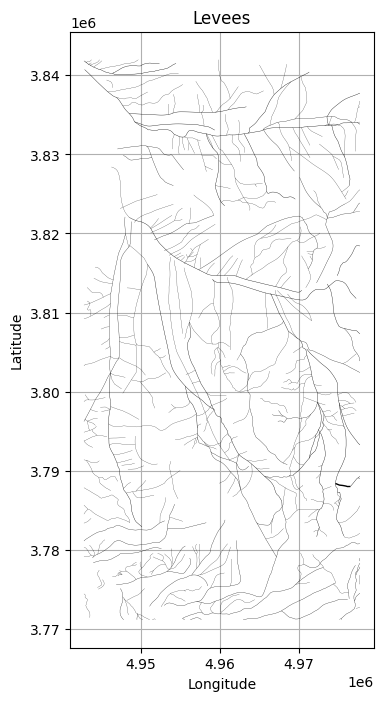

In [ ]:
# === Load shapefile ===
gdf = clipped

# === Filter by Type == 2 ===
gdf = gdf[gdf["Type"] == 2]
reference_file = gdf

if gdf.empty:
    raise ValueError("No features found with Type == 2.")

# === Define mapping from Size to linewidth ===
# You can adjust these if you want different visual scaling
size_to_width = {
    0.25: 0.15,
    0.5: 0.2,
    0.75: 0.25,
    1.0: 0.25
}

# Map 'Size' values to line widths (default to 1.0 if not in dict)
gdf["linewidth"] = gdf["Size"].map(size_to_width).fillna(1.0)

# === Plot ===
fig, ax = plt.subplots(figsize=(10, 8))
for lw, subset in gdf.groupby("linewidth"):
    subset.plot(ax=ax, linewidth=lw, edgecolor='black')

plt.title("Levees")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


In [ ]:
from Levees_DL.utils.metrics import compare_line_segments
import geopandas as gpd

# Compare reference and predicted line segments
metrics = compare_line_segments(
    reference_path=reference_file,
    predicted_path=edges_gdf,
    segment_length=1000,      # Segment lines into 250m pieces
    buffer_distance=90,   # 90m tolerance for matching
    output_path="comparison_output.gpkg",
    crs=3857                 # Use projected CRS (recommended)
)




print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")
print(f"IoU: {metrics['iou']:.4f}")

Segmenting reference lines into 1000m sections...
Reference: 471 lines → 1926 segments
Segmenting predicted lines into 1000m sections...
Predicted: 2220 lines → 3027 segments

--- Line Comparison Summary (1000m segments) ---
TP: 2148 segments, 1,331.72 km
FP: 879 segments, 395.03 km
FN: 323 segments, 262.21 km

--- Evaluation Metrics (Length-based) ---
Precision:  0.7712
Recall:     0.8355
F1 Score:   0.8021
IoU:        0.6696

Saved to: comparison_output.gpkg
Precision: 0.7712
Recall: 0.8355
F1 Score: 0.8021
IoU: 0.6696


6. Visualise the results



In [ ]:
#!pip install leaflet
!pip install leafmap
!pip install localtileserver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.8/662.8 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.4/20.4 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.6 MB/s eta 0:00:00
  Attempting uninstall: duckdb
    Found existing installation: duckdb 1.3.2
    Uninstalling duckdb-1.3.2:
      Successfully uninstalled duckdb-1.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 22.9 M

In [ ]:
import leafmap
from google.colab import output
output.enable_custom_widget_manager()

latitude = 31.52806
longitude = 65.24722

m = leafmap.Map(center=[latitude, longitude], zoom=14)

# Raster
raster_path = f"{basepath}/custom_comparison.tif"

palette = [
    "#e5350e",  # -1 FP
    "#0dff0d",  #  1 TP
    "#729bff",  #  2 FN
]

m.add_raster(
    raster_path,
    palette=palette,
    vmin=-1,
    vmax=2,
    nodata=0,
    layer_name="Raster Detection Results",
)

# Vector with style callback
vector_path = f"{basepath}/comparison_output.gpkg"

def style_function(feature):
    class_val = str(feature["properties"].get("class", ""))
    color_map = {
        "-1": "#e5350e",  # FP
        "1": "#0dff0d",   # TP
        "2": "#729bff",   # FN
    }
    color = color_map.get(class_val, "#808080")
    return {
        "color": color,
        "weight": 2,
        "fillColor": color,
        "fillOpacity": 0.3,
    }

m.add_vector(
    vector_path,
    style_callback=style_function,
    layer_name="Vector Detection Results",
)

# Legend
legend_dict = {
    "False Positives (FP)": "#e5350e",
    "True Positives (TP)": "#0dff0d",
    "False Negatives (FN)": "#729bff",
}

m.add_legend(title="Detection Results", legend_dict=legend_dict)
m.add_layer_control()
m